In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-data/sample_submission.csv
/kaggle/input/fraud-data/test_identity.csv
/kaggle/input/fraud-data/train_identity.csv
/kaggle/input/fraud-data/test_transaction.csv
/kaggle/input/fraud-data/train_transaction.csv


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# IMPORTS

In [5]:
!pip install dagshub mlflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 6.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 52.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 82.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import resample
import shap
import dagshub
from sklearn.base import clone as sk_clone
from sklearn.tree import DecisionTreeClassifier

In [7]:
dagshub.init(repo_owner='gkuch22', repo_name='ml-hw2-gkuch22', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=8279dcce-82ba-4d23-8de0-aba2a6066046&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=89a15eec7e79444a3f9cfaaf3b358d4e4bd3c6cd865b4adc993586a1be446ef3




Accessing as gkuch22

Initialized MLflow to track repo "gkuch22/ml-hw2-gkuch22"

Repository gkuch22/ml-hw2-gkuch22 initialized!

# DATA INSPECTION

In [6]:
df_transaction = pd.read_csv('/kaggle/input/fraud-data/train_transaction.csv')
df_identity = pd.read_csv('/kaggle/input/fraud-data/train_identity.csv')
df_transaction.shape, df_identity.shape

((590540, 394), (144233, 41))

# DATA MERGE

In [7]:
df_transaction['key_id'] = (
    df_transaction['card1'].astype(str) + '_' +
    df_transaction['addr1'].astype(str) + '_' +
    df_transaction['P_emaildomain'].astype(str)
)
df = df_transaction.merge(df_identity, how='left', on='TransactionID')

In [8]:
df.shape

(590540, 435)

In [9]:
df['key_id'].nunique()

90375

# UNDER SAMPLING

In [10]:
df.shape

(590540, 435)

In [11]:
fraud_df = df[df['isFraud'] == 1]
non_fraud_df = df[df['isFraud'] == 0]

non_fraud_undersampled = resample(non_fraud_df, replace=False, n_samples=3*len(fraud_df), random_state=42)

df_undersampled = pd.concat([fraud_df, non_fraud_undersampled])

df = df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
fraud_df.shape

(20663, 435)

In [13]:
df.shape

(82652, 435)

# DATA SPLIT

In [14]:
gss1 = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_valid_idx, test_idx = next(gss1.split(df, groups=df['key_id']))

train_valid_df = df.iloc[train_valid_idx]
test_df = df.iloc[test_idx]

gss2 = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=42)
train_idx, valid_idx = next(gss2.split(train_valid_df, groups=train_valid_df['key_id']))

train_df = train_valid_df.iloc[train_idx]
valid_df = train_valid_df.iloc[valid_idx]

X_train = train_df.drop(columns='isFraud')
y_train = train_df['isFraud']

X_valid = valid_df.drop(columns='isFraud')
y_valid = valid_df['isFraud']

X_test = test_df.drop(columns='isFraud')
y_test = test_df['isFraud']

In [15]:
X_train.shape, X_valid.shape, X_test.shape

((48455, 434), (17381, 434), (16816, 434))

In [ ]:
X_train

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,key_id,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
2,3268454,6875600,117.000,W,9592,532.0,150.0,mastercard,224.0,debit,143.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,8.0,1.0,524.0,524.0,175.0,524.0,175.0,NaN,NaN,NaN,NaN,210.0,NaN,NaN,NaN,NaN,454.0,NaN,NaN,NaN,M0,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9592_143.0_hotmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3231066,5

# CORREALATION FILTERING

In [43]:
class CustomCorrHandlerClass(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.drop_cols = []

    def fit(self, X, y):
        X = pd.DataFrame(X)
        
        corr_matrix = X.corr().abs()
        
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > self.threshold:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))      
        
        features_to_drop = []
        for feat1, feat2, _ in high_corr_pairs:
            if abs(X[feat1].corr(y)) < abs(X[feat2].corr(y)):
                features_to_drop.append(feat1)
            else:
                features_to_drop.append(feat2)
        features_to_drop = list(set(features_to_drop))
        
        self.drop_cols = list(set(features_to_drop))
        
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X)
        return X.drop(columns=self.drop_cols)
    

# TRAINING

In [48]:
import mlflow
from sklearn.base import clone as sk_clone
from itertools import product
from sklearn.ensemble import RandomForestClassifier

logged_model = 'runs:/582efd80ff784537ac9bb1899d586167/cleaning_pipeline'
cleaning = mlflow.sklearn.load_model(logged_model)

logged_model = 'runs:/f5cd3ddfd3424719967852382ccce82c/engineering_pipeline'
engineering = mlflow.sklearn.load_model(logged_model)
engineering.set_params(scaler='passthrough')

nunique_thresholds = [0.7]
nan_thresholds = [0.9]
onehot_thresholds = [5]
imputers = ['mean']
scalers = {'standard': StandardScaler()}

max_depths = [10]
min_samples_splits = [8]
min_samples_leafs = [6]
criterions = ['gini']

n_estimators = [100]
corr_thresholds = [0.9]

best_pipeline = None
best_roc_auc = 0
best_params = None

for uniquet in nunique_thresholds:
    for nant in nan_thresholds:
        for oht in onehot_thresholds:
            for imputer in imputers:
                for scaler_name, scaler in scalers.items():
                    for md, mss, crit, nest, msl, corr in product(max_depths, min_samples_splits, criterions, n_estimators, min_samples_leafs, corr_thresholds):
                        print()
                        print(f'uniquet={uniquet}, nt={nant}, oht={oht}, imputer={imputer}, scaler={scaler_name}')
                        print(f'md={md}, mss={mss}, crit={crit}, nest={nest}, msl={msl}, corr={corr}')
                        
                        cleaning_pipeline = sk_clone(cleaning)
                        engineering_pipeline = sk_clone(engineering)
                        
                        cleaning_pipeline.named_steps['nunique_handler'].threshold = uniquet
                        cleaning_pipeline.named_steps['nan_handler'].threshold = nant
    
                        engineering_pipeline.named_steps['onehot_encoder'].threshold = oht
                        engineering_pipeline.named_steps['imputer'].strategy = imputer

                        model = RandomForestClassifier(
                            max_depth=md,
                            min_samples_split=mss,
                            criterion=crit,
                            n_estimators=nest,
                            n_jobs=-1,
                            min_samples_leaf=msl
                        )
                        
                        pipeline = Pipeline(steps=[
                            ('cleaning', cleaning_pipeline),
                            ('engineering', engineering_pipeline),
                            ('selection', CustomCorrHandlerClass(corr)),
                            ('scaler', clone(scaler)),
                            ('model', model)
                        ])
                        
                        pipeline.fit(X_train, y_train)
                        
                        y_train_pred = pipeline.predict(X_train)
                        y_train_prob = pipeline.predict_proba(X_train)[:, 1]
                        
                        train_roc_auc = roc_auc_score(y_train, y_train_prob)
                        train_f1 = f1_score(y_train, y_train_pred)
                        print("TRAIN")
                        print(f"ROC AUC Score: {train_roc_auc}")
                        print(f"F1 Score: {train_f1}")
                        
                        
                        y_valid_pred = pipeline.predict(X_valid)
                        y_valid_prob = pipeline.predict_proba(X_valid)[:, 1]
                        
                        valid_roc_auc = roc_auc_score(y_valid, y_valid_prob)
                        valid_f1 = f1_score(y_valid, y_valid_pred)
                        print("VALID")
                        print(f"ROC AUC Score: {valid_roc_auc}")
                        print(f"F1 Score: {valid_f1}")
    
                        if valid_roc_auc > best_roc_auc:
                            best_roc_auc = valid_roc_auc
                            best_pipeline = pipeline
                            best_params = (uniquet, nant, oht, imputer, scaler_name, md, mss, crit, nest, msl, corr)

print()
print("-------------------------")
print("best params:", best_params)



uniquet=0.7, nt=0.9, oht=5, imputer=mean, scaler=standard
md=10, mss=8, crit=gini, nest=100, msl=6, corr=0.9
TRAIN
ROC AUC Score: 0.9183331758855955
F1 Score: 0.7191394735481202
VALID
ROC AUC Score: 0.8535768788277928
F1 Score: 0.5377812257564003

-------------------------
best params: (0.7, 0.9, 5, 'mean', 'standard', 10, 8, 'gini', 100, 6, 0.9)


# ANALYSIS

In [ ]:
# model = best_pipeline.named_steps['model']
# X_train_transformed = best_pipeline[:-1].transform(X_train)
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_train_transformed)
# shap.summary_plot(shap_values[1], X_train_transformed)

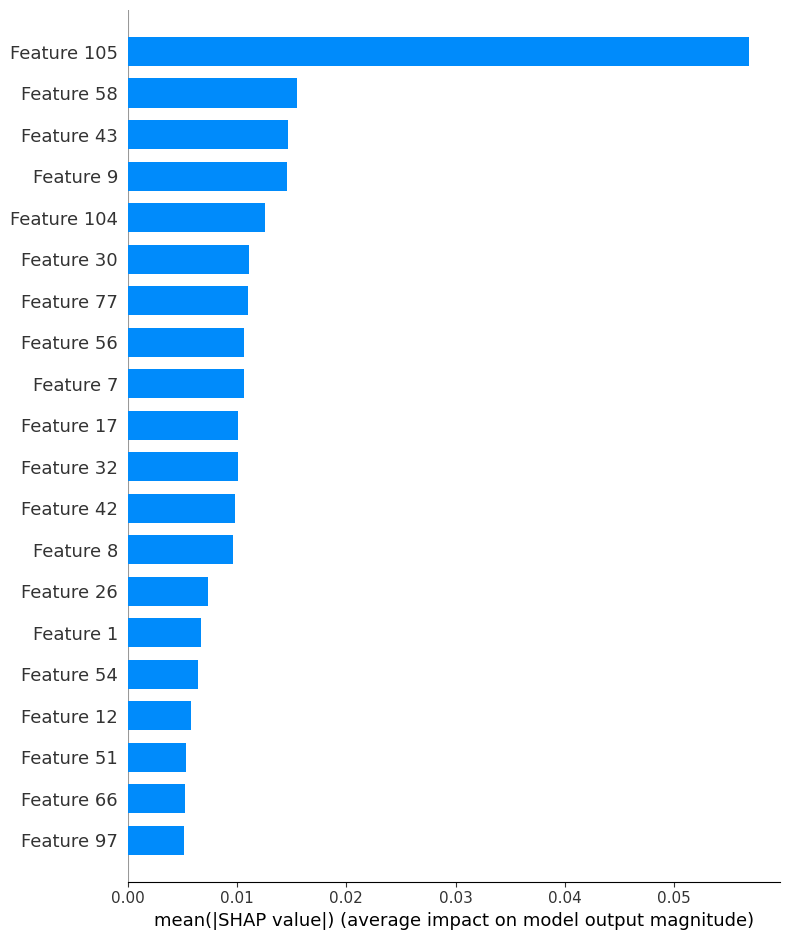

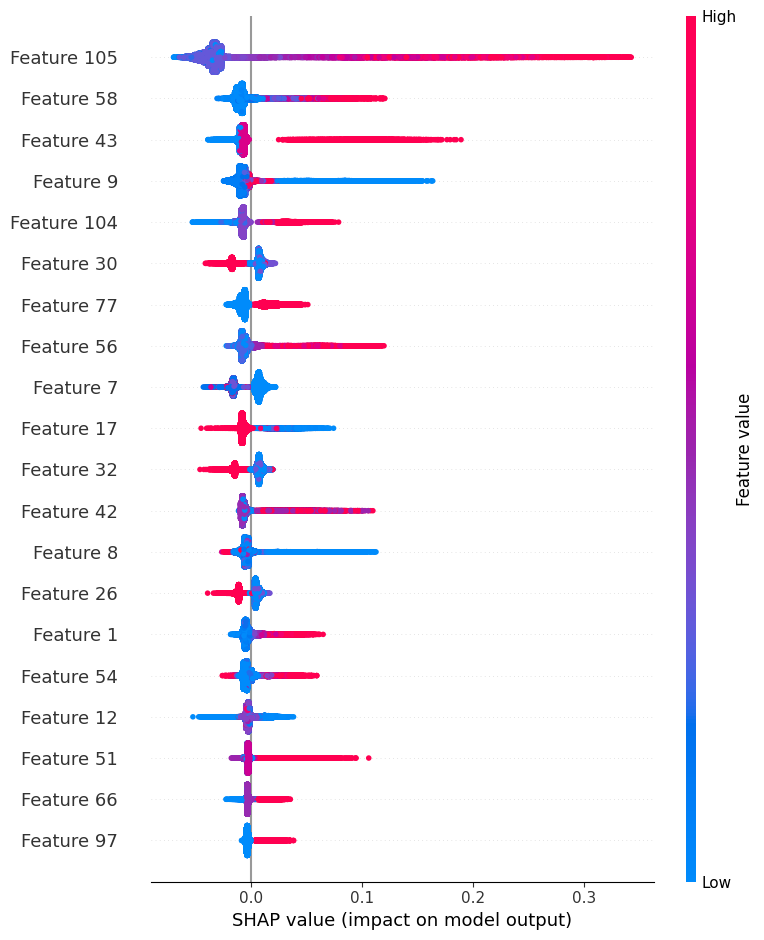

In [50]:
import shap

model = best_pipeline.named_steps['model']
preprocessor = Pipeline(best_pipeline.steps[:-1])
X_train_transformed = preprocessor.transform(X_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)
shap.summary_plot(shap_values[1], X_train_transformed, plot_type="bar")
shap.summary_plot(shap_values[1], X_train_transformed)

In [2]:
import matplotlib.pyplot as plt
plt.savefig("shap_summary_beeswarm.png")
plt.close()

In [8]:
import mlflow

experiment_name = "Random_Forest_Training"
run_name = "Random_Forest_SHAP"

mlflow.log_artifact("shap_summary_beeswarm.png")

# MLFLOW TRACKING

In [ ]:
# !pip install dagshub mlflow

In [ ]:
# import dagshub
# dagshub.init(repo_owner='gkuch22', repo_name='ml-hw2-gkuch22', mlflow=True)

In [46]:
experiment_name = "Random_Forest_Training"
run_name = "Random_Forest_Correlation_Filtering"

In [47]:
import mlflow

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name):

    mlflow.log_param("nunique_threshold", 0.7)
    mlflow.log_param("nan_threshold", 0.9)
    mlflow.log_param("categorical_threshold", 5)
    mlflow.log_param("a_encoder", "OneHotEncoder")
    mlflow.log_param("b_encoder", "WoeEncoder")
    mlflow.log_param("imputer_strategy", "mean")
    mlflow.log_param("scaler", "standard")
    
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("min_samples_split", 8)
    mlflow.log_param("min_samples_leaf", 6)
    mlflow.log_param("criterion", "gini")

    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("correaltion_threshold", 0.9)
    
    mlflow.log_param("model_type", "RandomForest")
    
    logged_model = 'runs:/582efd80ff784537ac9bb1899d586167/cleaning_pipeline'
    cleaning = mlflow.sklearn.load_model(logged_model)
    
    logged_model = 'runs:/f5cd3ddfd3424719967852382ccce82c/engineering_pipeline'
    engineering = mlflow.sklearn.load_model(logged_model)
    engineering.set_params(scaler='passthrough')
    
    nunique_thresholds = [0.7]
    nan_thresholds = [0.9]
    onehot_thresholds = [5]
    imputers = ['mean']
    scalers = {'standard': StandardScaler()}
    
    max_depths = [10]
    min_samples_splits = [8]
    min_samples_leafs = [6]
    criterions = ['gini']
    
    n_estimators = [100]
    corr_thresholds = [0.9]
    
    best_pipeline = None
    best_roc_auc = 0
    best_params = None
    
    for uniquet in nunique_thresholds:
        for nant in nan_thresholds:
            for oht in onehot_thresholds:
                for imputer in imputers:
                    for scaler_name, scaler in scalers.items():
                        for md, mss, crit, nest, msl, corr in product(max_depths, min_samples_splits, criterions, n_estimators, min_samples_leafs, corr_thresholds):
                            print()
                            print(f'uniquet={uniquet}, nt={nant}, oht={oht}, imputer={imputer}, scaler={scaler_name}')
                            print(f'md={md}, mss={mss}, crit={crit}, nest={nest}, msl={msl}, corr={corr}')
                            
                            cleaning_pipeline = sk_clone(cleaning)
                            engineering_pipeline = sk_clone(engineering)
                            
                            cleaning_pipeline.named_steps['nunique_handler'].threshold = uniquet
                            cleaning_pipeline.named_steps['nan_handler'].threshold = nant
        
                            engineering_pipeline.named_steps['onehot_encoder'].threshold = oht
                            engineering_pipeline.named_steps['imputer'].strategy = imputer
    
                            model = RandomForestClassifier(
                                max_depth=md,
                                min_samples_split=mss,
                                criterion=crit,
                                n_estimators=nest,
                                n_jobs=-1,
                                min_samples_leaf=msl
                            )
                            
                            pipeline = Pipeline(steps=[
                                ('cleaning', cleaning_pipeline),
                                ('engineering', engineering_pipeline),
                                ('selection', CustomCorrHandlerClass(corr)),
                                ('scaler', clone(scaler)),
                                ('model', model)
                            ])
                            
                            pipeline.fit(X_train, y_train)
    
                            y_train_pred = pipeline.predict(X_train)
                            y_train_prob = pipeline.predict_proba(X_train)[:, 1]

                            train_roc_auc = roc_auc_score(y_train, y_train_prob)
                            train_accuracy = accuracy_score(y_train, y_train_pred)
                            train_precision = precision_score(y_train, y_train_pred)
                            train_recall = recall_score(y_train, y_train_pred)
                            train_f1 = f1_score(y_train, y_train_pred)
                            print("TRAIN")
                            print(f"ROC AUC Score: {train_roc_auc}")
                            print(f"F1 Score: {train_f1}")
                            print(f"Recall: {train_recall}")
                            print(f"Precision: {train_precision}")
                            print(f"Accuracy: {train_accuracy}")
                            
                            
                            y_valid_pred = pipeline.predict(X_valid)
                            y_valid_prob = pipeline.predict_proba(X_valid)[:, 1]
                            
                            valid_roc_auc = roc_auc_score(y_valid, y_valid_prob)
                            valid_accuracy = accuracy_score(y_valid, y_valid_pred)
                            valid_precision = precision_score(y_valid, y_valid_pred)
                            valid_recall = recall_score(y_valid, y_valid_pred)
                            valid_f1 = f1_score(y_valid, y_valid_pred)
                            print("VALID")
                            print(f"ROC AUC Score: {valid_roc_auc}")
                            print(f"F1 Score: {valid_f1}")
                            print(f"Recall: {valid_recall}")
                            print(f"Precision: {valid_precision}")
                            print(f"Accuracy: {valid_accuracy}")
                            
                            if valid_roc_auc > best_roc_auc:
                                best_roc_auc = valid_roc_auc
                                best_pipeline = pipeline
                                best_params = (uniquet, nant, oht, imputer, scaler_name)

                            mlflow.log_metric("roc_auc/train", train_roc_auc)
                            mlflow.log_metric("roc_auc/valid", valid_roc_auc)
                            
                            mlflow.log_metric("f1/train", train_f1)
                            mlflow.log_metric("f1/valid", valid_f1)
                            
                            mlflow.log_metric("recall/train", train_recall)
                            mlflow.log_metric("recall/valid", valid_recall)
                            
                            mlflow.log_metric("precision/train", train_precision)
                            mlflow.log_metric("precision/valid", valid_precision)
                            
                            mlflow.log_metric("accuracy/train", train_accuracy)
                            mlflow.log_metric("accuracy/valid", valid_accuracy)

                            mlflow.sklearn.log_model(pipeline, "model")



uniquet=0.7, nt=0.9, oht=5, imputer=mean, scaler=standard
md=10, mss=8, crit=gini, nest=100, msl=6, corr=0.9
TRAIN
ROC AUC Score: 0.9183590270706843
F1 Score: 0.7242891790082048
Recall: 0.5968194574368568
Precision: 0.920997375328084
Accuracy: 0.8897327417191209
VALID
ROC AUC Score: 0.8529612773405411
F1 Score: 0.5405992858251824
Recall: 0.38577442942610235
Precision: 0.9030082987551867
Accuracy: 0.8297566308037512


2025/04/24 08:29:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random_Forest_Correlation_Filtering at: https://dagshub.com/gkuch22/ml-hw2-gkuch22.mlflow/#/experiments/2/runs/a8574e5d438c4cccb73ac17abb28bd1d
🧪 View experiment at: https://dagshub.com/gkuch22/ml-hw2-gkuch22.mlflow/#/experiments/2
